# Title: Hartree-Fock (HF) Approximatation and Pyscf
## 1. Basic Concepts and Mathematical Foundation

In quantum chemistry, molecular orbitals are expressed as linear combinations of basis functions:

$\phi_i(r) = \sum_k c_k \chi_k(r)$

where:
- $\phi_i(r)$ is the molecular orbital
- $\chi_k(r)$ are the basis functions
- $c_k$ are expansion coefficients



## 2. Structure of Basis Functions

The basis function $\chi_k(r)$ has both angular and radial components:

$\chi_k(r) = \sum Y_{lm}(r) \sum \beta_{m,k} e^{(-\alpha_{m,k} |r|^2)}$

Let's break down each component:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyscf
import pyqmc.api as pyq
from pyscf import gto, scf
%matplotlib inline

In [3]:
def make_plot(coords, wfval, X, Y, outfile=None):
    cs=list(range(4))
    fig, axes = plt.subplots(1, len(cs), figsize=(len(cs)*4,8), sharey=True)
    maval = np.max(wfval)
    for c, ax in zip(cs, axes):
        cmap = ax.imshow(np.abs(wfval[c].reshape(X.shape))**2, origin = 'lower', extent=(xmin,xmax,ymin,ymax), cmap='Blues')
        for xy in coords.configs[c,1:]:
            ax.plot(xy[1],xy[2],marker='o', color='r', mew=1, mec='k', markersize=5)
        for atompos in mol.atom_coords():
            ax.plot(atompos[1],atompos[2],marker='o', color='w', mew=1, mec='k', markersize=20)
        ax.set_title(str(c))
        #plt.colorbar(cmap)
    if outfile is not None:
        plt.savefig(outfile, dpi=200)

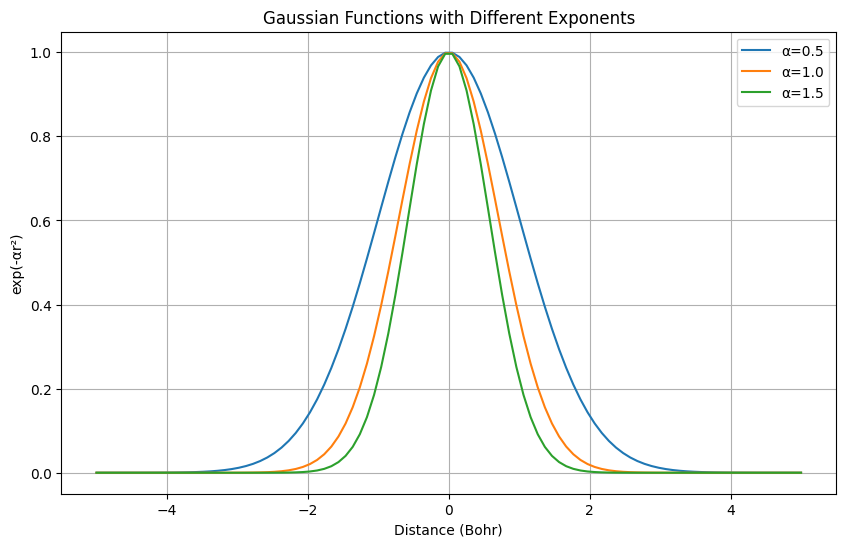

In [5]:
def gaussian(r, alpha):
    """Basic Gaussian function: exp(-αr²)"""
    return np.exp(-alpha * r**2)

r = np.linspace(-5, 5, 100)
alphas = [0.5, 1.0, 1.5]

plt.figure(figsize=(10, 6))

for alpha in alphas:
    plt.plot(r, gaussian(r, alpha), label=f'α={alpha}')
plt.title('Gaussian Functions with Different Exponents')
plt.xlabel('Distance (Bohr)')
plt.ylabel('exp(-αr²)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Primitive Gaussian Type Orbitals (GTOs)

GTOs include both radial and angular parts:

$g(r) = N r^n exp(-\alpha r^2)$

where:
- N: normalization constant
- n: angular momentum quantum number (s:0, p:1, d:2)
- α: orbital exponent

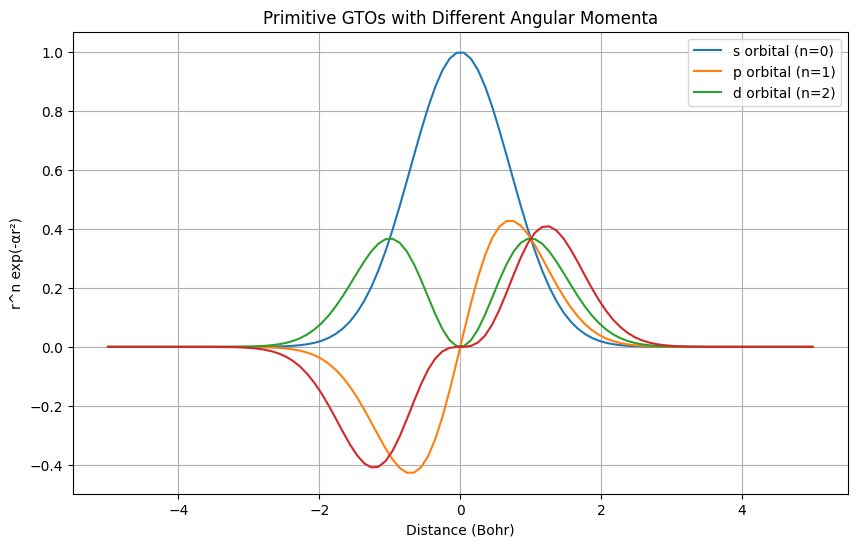

In [7]:
def primitive_gto(r, alpha, n=0):
    """Primitive GTO with angular momentum n"""
    return r**n * np.exp(-alpha * r**2)

plt.figure(figsize=(10,6))
for n in [0,1,2,3]: # s, p, d orbitals
    plt.plot(r, primitive_gto(r, 1.0, n), label=f'n={n}')

plt.title('Primitive GTOs with Different Angular Momenta')
plt.xlabel('Distance (Bohr)')
plt.ylabel('r^n exp(-αr²)')
plt.legend(['s orbital (n=0)', 'p orbital (n=1)', 'd orbital (n=2)'])
plt.grid(True)
plt.show()

# 4. Radial Basis Functions and Contracted GTOs
The radial part of basis functions can be constructed using combinations of primitive Gaussian functions:

$R(r) = \sum_i d_i g_i(r)$

where primitive GTOs are:

$g_i(r) = N_i r^n exp(-\alpha_i r^2)$

The complete basis function is then:

$\chi(r) = Y_{lm}(\theta,\phi) R(r)$

$d_i$: contraction coefficients\
$N_i$: normalization constant\
$n$: angular momentum quantum number\
$\alpha_i$: orbital exponents\
$Y_{lm}$: spherical harmonics

This contraction scheme helps approximate Slater-type orbitals more efficiently.

[[0, [3.42525091, 0.15432897], [0.62391373, 0.53532814], [0.1688554, 0.44463454]]]


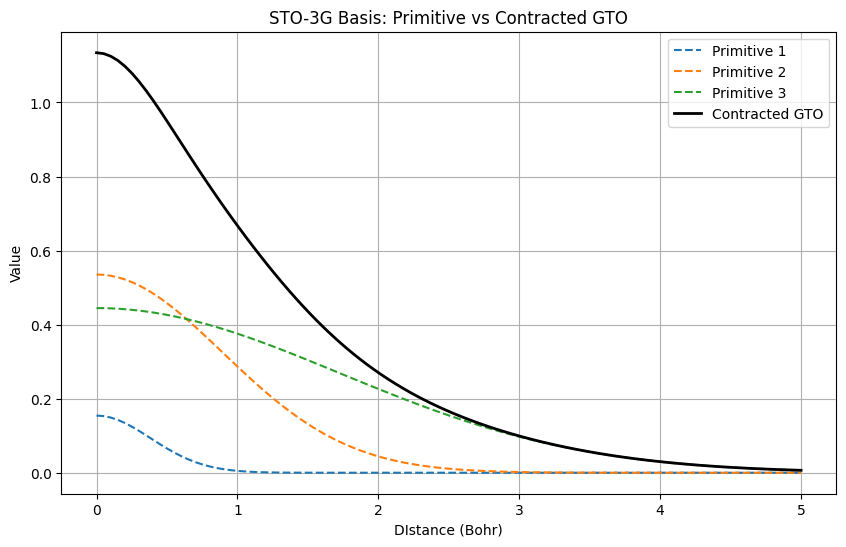

Exponents (α): [3.42525091, 0.62391373, 0.1688554]
Contraction coefficients (d): [0.15432897, 0.53532814, 0.44463454]


In [19]:
def contracted_gto(r, alphas, coeffs, n):
    """contracted GTO function"""
    result = np.zeros_like(r)
    for alpha, coeff in zip(alphas, coeffs):
        result += coeff * r **n * np.exp(-alpha * r**2)
    return result

# STO-3G for hydrogen 1s orbital
mol = gto.M(
    atom='H 0 0 0',
    basis='sto-3g',
    spin=1,
    charge=0
)

basis_params = mol._basis['H'][0]
angular_momentum = basis_params[0]
basis_params = basis_params[1:]

alphas = [param[0] for param in basis_params]
coeffs = [param[1] for param in basis_params]

r = np.linspace(0,5,100)
plt.figure(figsize = (10, 6))

for i, (alpha, coeff) in enumerate(zip(alphas, coeffs)):
    plt.plot(r, coeff * np.exp(-alpha * r**2), '--', label = f"Primitive {i+1}")

plt.plot(r, contracted_gto(r, alphas, coeffs, angular_momentum), 'k-', linewidth = 2, label = "Contracted GTO")

plt.title("STO-3G Basis: Primitive vs Contracted GTO")
plt.xlabel("DIstance (Bohr)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

print("Exponents (α):", alphas)
print("Contraction coefficients (d):", coeffs)

# 5. Understanding Basis Sets in Quantum Chemistry

## 1) Introduction to Basis Sets
A basis set is a set of functions used to create molecular orbitals:
$\phi_i(r) = \sum_k c_k \chi_k(r)$

## 2) Types of Basis Sets

### 2.1) Minimal Basis Sets
- Uses n Gaussian functions to approximate each orbital
- Example: STO-3G for 1s orbital
  $\chi(r) = \sum_{i=1}^3 d_i e^{-\alpha_i r^2}$

### 2.2) Split-Valence Basis Sets
- X-YZG notation (e.g., 6-31G)
    - X: number of primitive for core orbitals
    - Y, Z: split-valence description
- Examples:
   - 3-21G: core(3), inner valence(2), outer valence(1)
   - 6-31G: core(6), inner valence(3), outer valence(1)
   - Core orbitals: Less important for chemical bonding, thus represented with fixed form
   - Valence orbitals: Critical for chemical bonding, thus given more flexibility in their representation
  



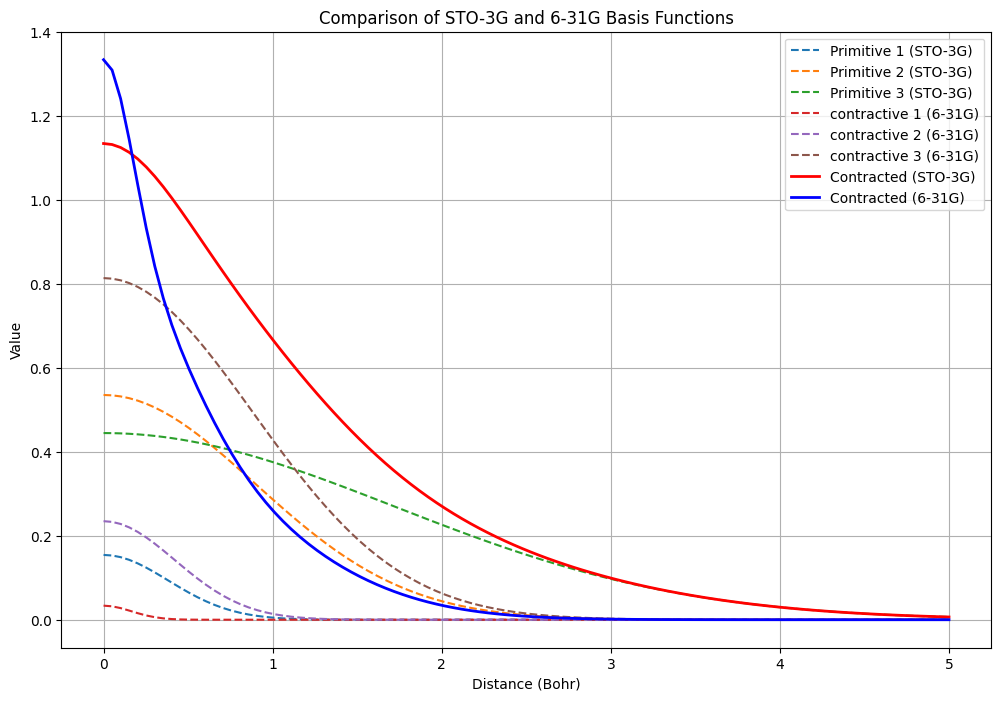

In [171]:
# STO-3G
mol_sto3g = gto.M(
    atom = "H 0 0 0",
    basis = 'sto-3g',
    spin = 1,
    charge = 0,
)

basis_sto3g = mol_sto3g._basis['H'][0]
angular_momentum_sto3g = basis_sto3g[0]
gto_params_sto3g = basis_sto3g[1:]
alphas_sto3g = [param[0] for param in gto_params_sto3g]
coeffs_sto3g = [param[1] for param in gto_params_sto3g]

# 631
mol_631g = gto.M(
    atom = 'H 0 0 0',
    basis = '6-31g',
    spin = 1,
    charge = 0
)

basis_631g = mol_631g._basis['H'][0]
angular_momentum_631g = basis_631g[0]
gto_params_631g = basis_631g[1:]
alphas_631g = [param[0] for param in gto_params_631g]
coeffs_631g = [param[1] for param in gto_params_631g]

# Plotting

r = np.linspace(0, 5, 100)
plt.figure(figsize=(12,8))


# Plot primitives for STO-3G
for i, (alpha, coeff) in enumerate(zip(alphas_sto3g, coeffs_sto3g)):
   primitive = coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (STO-3G)')

# Plot primitives for 6-31G
for i, (alpha, coeff) in enumerate(zip(alphas_631g, coeffs_631g)):
   primitive = coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'contractive {i+1} (6-31G)')

# Contracted for STO-3G
contracted_sto3g = np.zeros_like(r)
for alpha, coeff in zip(alphas_sto3g, coeffs_sto3g):
    contracted_sto3g += coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
plt.plot(r, contracted_sto3g, 'r-', linewidth=2, label='Contracted (STO-3G)')

# Contracted for 6-31G
contracted_631g = np.zeros_like(r)
for alpha, coef in zip(alphas_631g, coeffs_631g):
    contracted_631g += coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
plt.plot(r, contracted_631g, 'b-', linewidth = 2, label="Contracted (6-31G)")

plt.title('Comparison of STO-3G and 6-31G Basis Functions')
plt.xlabel('Distance (Bohr)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 1s orbital for C

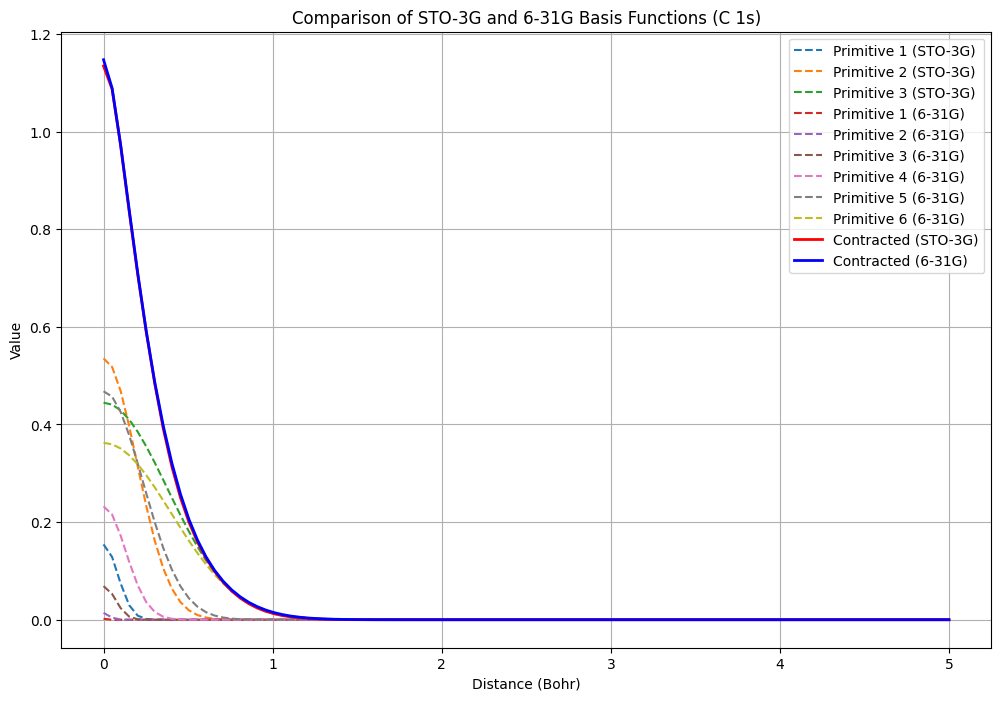

STO-3G 1s orbital parameters:
Angular momentum: 0
Exponents (α): [71.616837, 13.045096, 3.5305122]
Coefficients (d): [0.15432897, 0.53532814, 0.44463454]

6-31G 1s orbital parameters:
Angular momentum: 0
Exponents (α): [3047.5249, 457.36951, 103.94869, 29.210155, 9.286663, 3.163927]
Coefficients (d): [0.0018347, 0.0140373, 0.0688426, 0.2321844, 0.4679413, 0.362312]


In [21]:
# STO-3G
mol_sto3g = gto.M(
   atom='C 0 0 0',
   basis='sto-3g',
   spin=0,
   charge=0
)

# 6-31G
mol_631g = gto.M(
   atom='C 0 0 0',
   basis='6-31g',
   spin=0,
   charge=0
)

# Plot core (1s) orbitals first
basis_sto3g = mol_sto3g._basis['C'][0]  # 1s orbital:0
basis_631g = mol_631g._basis['C'][0]    # 1s orbital:0

angular_momentum_sto3g = basis_sto3g[0]
gto_params_sto3g = basis_sto3g[1:]
alphas_sto3g = [param[0] for param in gto_params_sto3g]
coeffs_sto3g = [param[1] for param in gto_params_sto3g]

angular_momentum_631g = basis_631g[0]
gto_params_631g = basis_631g[1:]
alphas_631g = [param[0] for param in gto_params_631g]
coeffs_631g = [param[1] for param in gto_params_631g]

r = np.linspace(0, 5, 100)
plt.figure(figsize=(12,8))

# Plot primitives for STO-3G
for i, (alpha, coeff) in enumerate(zip(alphas_sto3g, coeffs_sto3g)):
   primitive = coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (STO-3G)')

# Plot primitives for 6-31G
for i, (alpha, coeff) in enumerate(zip(alphas_631g, coeffs_631g)):
   primitive = coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (6-31G)')
    
# Plot contracted for STO-3G
contracted_sto3g = np.zeros_like(r)
for alpha, coeff in zip(alphas_sto3g, coeffs_sto3g):
   contracted_sto3g += coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
plt.plot(r, contracted_sto3g, 'r-', linewidth=2, label='Contracted (STO-3G)')

# Plot contracted for 6-31G
contracted_631g = np.zeros_like(r)
for alpha, coeff in zip(alphas_631g, coeffs_631g):
   contracted_631g += coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
plt.plot(r, contracted_631g, 'b-', linewidth=2, label='Contracted (6-31G)')

plt.title('Comparison of STO-3G and 6-31G Basis Functions (C 1s)')
plt.xlabel('Distance (Bohr)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("STO-3G 1s orbital parameters:")
print("Angular momentum:", angular_momentum_sto3g)
print("Exponents (α):", alphas_sto3g)
print("Coefficients (d):", coeffs_sto3g)
print("\n6-31G 1s orbital parameters:")
print("Angular momentum:", angular_momentum_631g)
print("Exponents (α):", alphas_631g)
print("Coefficients (d):", coeffs_631g)

## 2S orbital

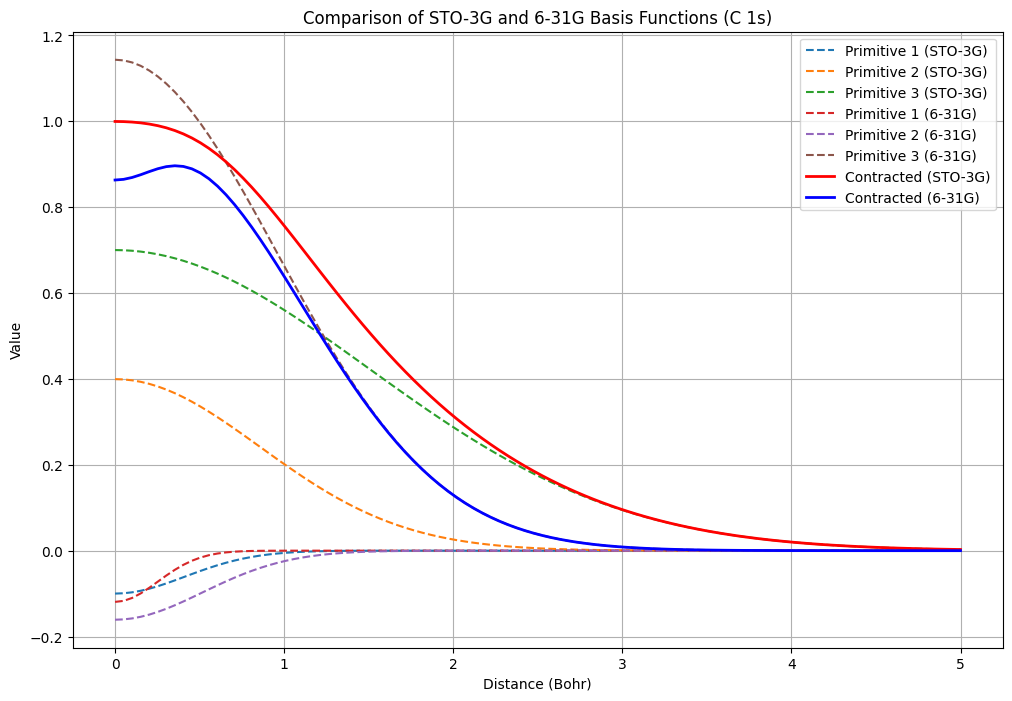

STO-3G 1s orbital parameters:
Angular momentum: 0
Exponents (α): [2.9412494, 0.6834831, 0.2222899]
Coefficients (d): [-0.09996723, 0.39951283, 0.70011547]

6-31G 1s orbital parameters:
Angular momentum: 0
Exponents (α): [7.8682724, 1.8812885, 0.5442493]
Coefficients (d): [-0.1193324, -0.1608542, 1.1434564]


In [186]:
# STO-3G
mol_sto3g = gto.M(
   atom='C 0 0 0',
   basis='sto-3g',
   spin=0,
   charge=0
)

# 6-31G
mol_631g = gto.M(
   atom='C 0 0 0',
   basis='6-31g',
   spin=0,
   charge=0
)

# Plot inner orbitals second
basis_sto3g = mol_sto3g._basis['C'][1]  # 2s orbital:1
basis_631g = mol_631g._basis['C'][1]    # 2s orbital:1

angular_momentum_sto3g = basis_sto3g[0]
gto_params_sto3g = basis_sto3g[1:]
alphas_sto3g = [param[0] for param in gto_params_sto3g]
coeffs_sto3g = [param[1] for param in gto_params_sto3g]

angular_momentum_631g = basis_631g[0]
gto_params_631g = basis_631g[1:]
alphas_631g = [param[0] for param in gto_params_631g]
coeffs_631g = [param[1] for param in gto_params_631g]

r = np.linspace(0, 5, 100)
plt.figure(figsize=(12,8))

# Plot primitives for STO-3G
for i, (alpha, coeff) in enumerate(zip(alphas_sto3g, coeffs_sto3g)):
   primitive = coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (STO-3G)')

# Plot primitives for 6-31G
for i, (alpha, coeff) in enumerate(zip(alphas_631g, coeffs_631g)):
   primitive = coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (6-31G)')

# Plot contracted for STO-3G
contracted_sto3g = np.zeros_like(r)
for alpha, coeff in zip(alphas_sto3g, coeffs_sto3g):
   contracted_sto3g += coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
plt.plot(r, contracted_sto3g, 'r-', linewidth=2, label='Contracted (STO-3G)')

# Plot contracted for 6-31G
contracted_631g = np.zeros_like(r)
for alpha, coeff in zip(alphas_631g, coeffs_631g):
   contracted_631g += coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
plt.plot(r, contracted_631g, 'b-', linewidth=2, label='Contracted (6-31G)')

plt.title('Comparison of STO-3G and 6-31G Basis Functions (C 1s)')
plt.xlabel('Distance (Bohr)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("STO-3G 1s orbital parameters:")
print("Angular momentum:", angular_momentum_sto3g)
print("Exponents (α):", alphas_sto3g)
print("Coefficients (d):", coeffs_sto3g)
print("\n6-31G 1s orbital parameters:")
print("Angular momentum:", angular_momentum_631g)
print("Exponents (α):", alphas_631g)
print("Coefficients (d):", coeffs_631g)

## 2p orbital

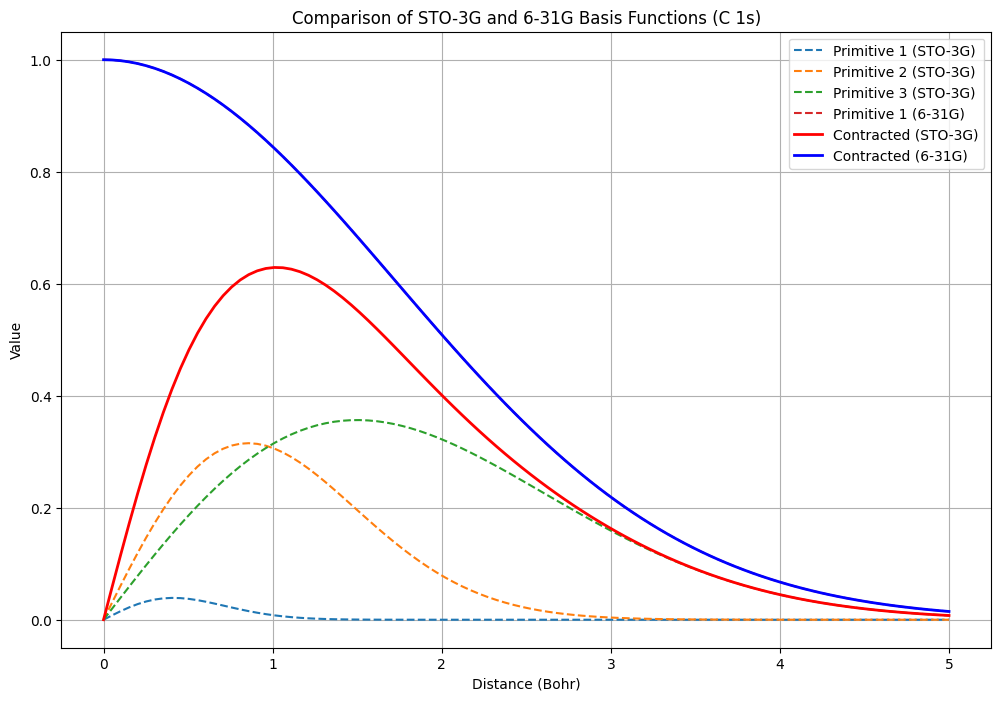

STO-3G 1s orbital parameters:
Angular momentum: 1
Exponents (α): [2.9412494, 0.6834831, 0.2222899]
Coefficients (d): [0.15591627, 0.60768372, 0.39195739]

6-31G 1s orbital parameters:
Angular momentum: 0
Exponents (α): [0.1687144]
Coefficients (d): [1.0]


In [184]:
# STO-3G
mol_sto3g = gto.M(
   atom='C 0 0 0',
   basis='sto-3g',
   spin=0,
   charge=0
)

# 6-31G
mol_631g = gto.M(
   atom='C 0 0 0',
   basis='6-31g',
   spin=0,
   charge=0
)

# Plot outer valence orbitals third
basis_sto3g = mol_sto3g._basis['C'][2]  # 2p orbital:2
basis_631g = mol_631g._basis['C'][2]    # 2p orbital:2

angular_momentum_sto3g = basis_sto3g[0]
gto_params_sto3g = basis_sto3g[1:]
alphas_sto3g = [param[0] for param in gto_params_sto3g]
coeffs_sto3g = [param[1] for param in gto_params_sto3g]

angular_momentum_631g = basis_631g[0]
gto_params_631g = basis_631g[1:]
alphas_631g = [param[0] for param in gto_params_631g]
coeffs_631g = [param[1] for param in gto_params_631g]

r = np.linspace(0, 5, 100)
plt.figure(figsize=(12,8))

# Plot primitives for STO-3G
for i, (alpha, coeff) in enumerate(zip(alphas_sto3g, coeffs_sto3g)):
   primitive = coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (STO-3G)')

# Plot primitives for 6-31G
for i, (alpha, coeff) in enumerate(zip(alphas_631g, coeffs_631g)):
   primitive = coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (6-31G)')

# Plot contracted for STO-3G
contracted_sto3g = np.zeros_like(r)
for alpha, coeff in zip(alphas_sto3g, coeffs_sto3g):
   contracted_sto3g += coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
plt.plot(r, contracted_sto3g, 'r-', linewidth=2, label='Contracted (STO-3G)')

# Plot contracted for 6-31G
contracted_631g = np.zeros_like(r)
for alpha, coeff in zip(alphas_631g, coeffs_631g):
   contracted_631g += coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
plt.plot(r, contracted_631g, 'b-', linewidth=2, label='Contracted (6-31G)')

plt.title('Comparison of STO-3G and 6-31G Basis Functions (C 1s)')
plt.xlabel('Distance (Bohr)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("STO-3G 1s orbital parameters:")
print("Angular momentum:", angular_momentum_sto3g)
print("Exponents (α):", alphas_sto3g)
print("Coefficients (d):", coeffs_sto3g)
print("\n6-31G 1s orbital parameters:")
print("Angular momentum:", angular_momentum_631g)
print("Exponents (α):", alphas_631g)
print("Coefficients (d):", coeffs_631g)

In [31]:
mol_631g._basis['C']

[[0,
  [3047.5249, 0.0018347],
  [457.36951, 0.0140373],
  [103.94869, 0.0688426],
  [29.210155, 0.2321844],
  [9.286663, 0.4679413],
  [3.163927, 0.362312]],
 [0, [7.8682724, -0.1193324], [1.8812885, -0.1608542], [0.5442493, 1.1434564]],
 [0, [0.1687144, 1.0]],
 [1, [7.8682724, 0.0689991], [1.8812885, 0.316424], [0.5442493, 0.7443083]],
 [1, [0.1687144, 1.0]]]

In [33]:
mol_sto3g._basis['C']

[[0,
  [71.616837, 0.15432897],
  [13.045096, 0.53532814],
  [3.5305122, 0.44463454]],
 [0,
  [2.9412494, -0.09996723],
  [0.6834831, 0.39951283],
  [0.2222899, 0.70011547]],
 [1,
  [2.9412494, 0.15591627],
  [0.6834831, 0.60768372],
  [0.2222899, 0.39195739]]]

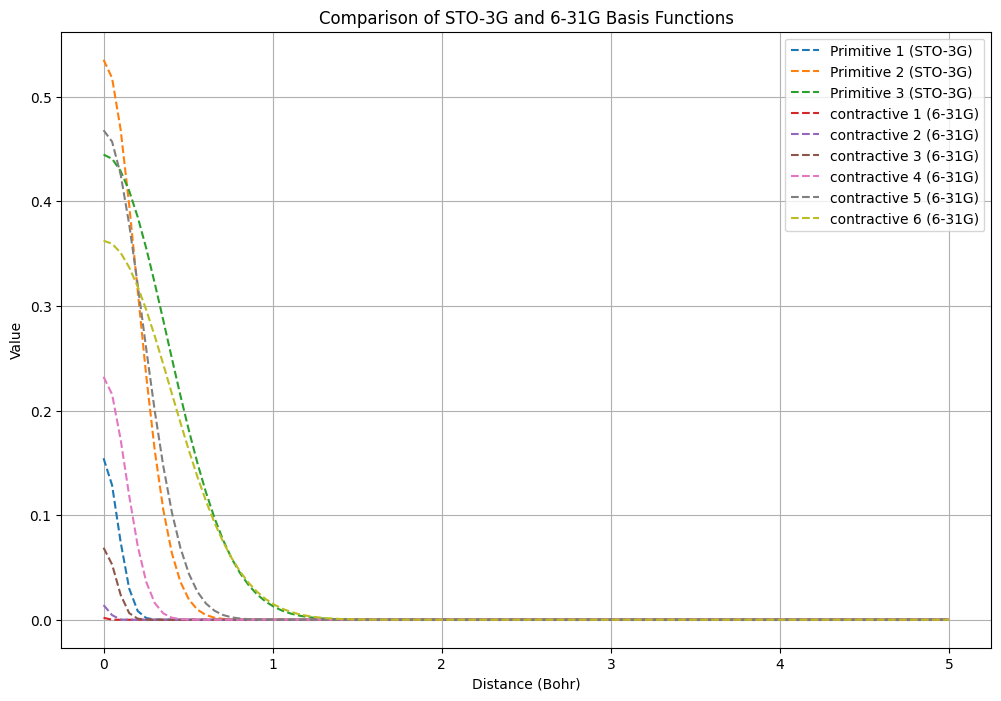

In [25]:
# More complicted one e.g., Carbon

mol_sto3g = gto.M(
   atom='C 0 0 0',
   basis='sto-3g',
   spin=0,
   charge=0
)

mol_631g = gto.M(
   atom='C 0 0 0',
   basis='6-31g',
   spin=0,
   charge=0
)

basis_631g = mol_631g._basis['C'][0]
angular_momentum_631g = basis_631g[0]
gto_params_631g = basis_631g[1:]
alphas_631g = [param[0] for param in gto_params_631g]
coeffs_631g = [param[1] for param in gto_params_631g]

# Plotting

r = np.linspace(0, 5, 100)
plt.figure(figsize=(12,8))


# Plot primitives for STO-3G
for i, (alpha, coeff) in enumerate(zip(alphas_sto3g, coeffs_sto3g)):
   primitive = coeff * r**angular_momentum_sto3g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'Primitive {i+1} (STO-3G)')

# Plot primitives for 6-31G
for i, (alpha, coeff) in enumerate(zip(alphas_631g, coeffs_631g)):
   primitive = coeff * r**angular_momentum_631g * np.exp(-alpha * r**2)
   plt.plot(r, primitive, '--', label=f'contractive {i+1} (6-31G)')

plt.title('Comparison of STO-3G and 6-31G Basis Functions')
plt.xlabel('Distance (Bohr)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 640x480 with 0 Axes>

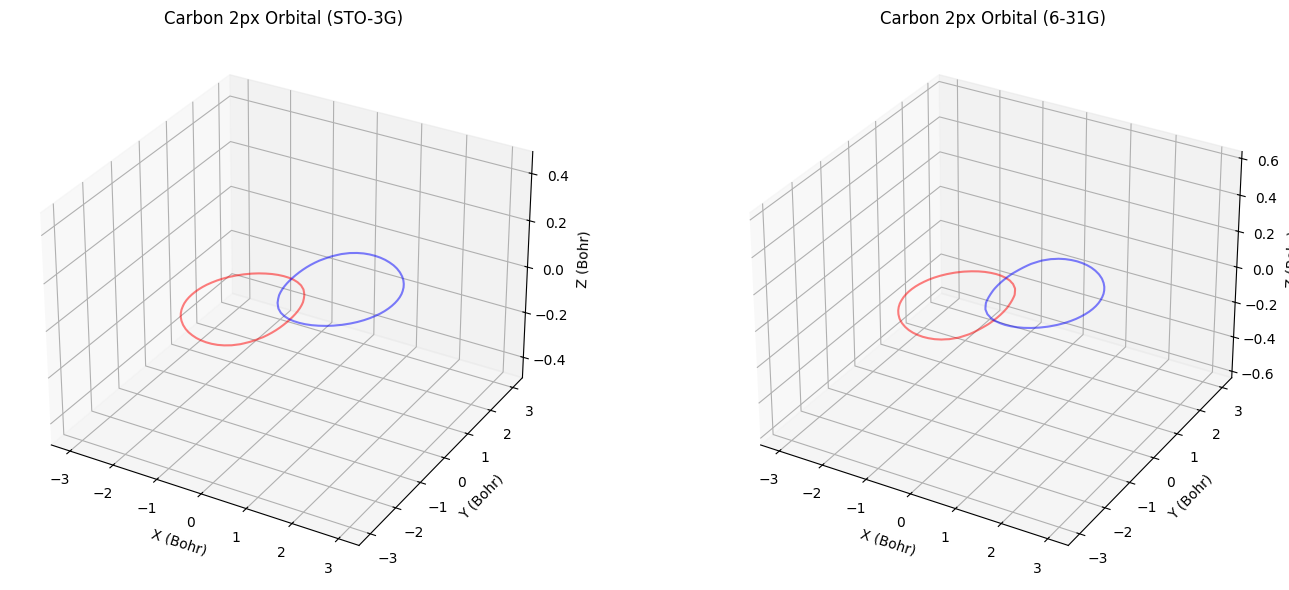

In [106]:
from scipy.special import sph_harm
from mpl_toolkits.mplot3d import Axes3D

grid_points = 50
x = np.linspace(-3, 3, grid_points)
y = np.linspace(-3, 3, grid_points)
z = np.linspace(-3, 3, grid_points)
coords = np.meshgrid(x, y, z, indexing='ij')
coords = np.stack(coords, axis=-1)
coords_reshape = coords.reshape(-1,3)

ao_values_sto3g = mol_sto3g.eval_gto("GTOval_sph", coords_reshape)
ao_values_631g = mol_631g.eval_gto('GTOval_sph', coords_reshape) # (125000, 3) --> orbital index

plt.clf()

orbital_idx_sto3g = 2  # 2px for STO-3G
orbital_idx_631g = 3   # 2px for 6-31G

orbital_values_sto3g = ao_values_sto3g[:, orbital_idx_sto3g].reshape(grid_points, grid_points, grid_points)
orbital_values_631g = ao_values_631g[:, orbital_idx_631g].reshape(grid_points, grid_points, grid_points)


fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(121, projection='3d')
iso_val = 0.1
ax1.contour(coords[0,:,:,1], 
            coords[:,0,:,2], 
            orbital_values_sto3g[:,:,grid_points//2],
            levels=[-iso_val, iso_val], 
            colors=['r', 'b'], 
            alpha=0.5)

ax1.set_title('Carbon 2px Orbital (STO-3G)')
ax1.set_xlabel('X (Bohr)')
ax1.set_ylabel('Y (Bohr)')
ax1.set_zlabel('Z (Bohr)')

ax2 = fig.add_subplot(122, projection='3d')
ax2.contour(coords[20,:,:,1], 
            coords[:,20,:,2], 
            orbital_values_631g[:,:,grid_points//2],
            levels=[-iso_val, iso_val], 
            colors=['r', 'b'], 
            alpha=0.5)

ax2.set_title('Carbon 2px Orbital (6-31G)')
ax2.set_xlabel('X (Bohr)')
ax2.set_ylabel('Y (Bohr)')
ax2.set_zlabel('Z (Bohr)')

plt.tight_layout()
plt.show()

In [39]:
import pyscf.gto as gto
import numpy as np
from scipy.special import sph_harm

# 탄소 원자 정의
mol_sto3g = gto.M(
    atom='C 0 0 0',
    basis='6-31g',
    spin=0,
    charge=0
)

# 기저함수 파라미터 추출
basis_params = mol_sto3g._basis['C']

def complete_gto(r, theta, phi, alphas, coeffs, l, m):
    """
    Complete GTO with radial and angular parts
    """
    # Radial part
    R = np.zeros_like(r, dtype=complex)
    for alpha, coeff in zip(alphas, coeffs):
        R += coeff * r**l * np.exp(-alpha * r**2)
    
    # Angular part
    Y = sph_harm(m, l, phi, theta)
    
    return R * Y

def kinetic_operator(r, theta, phi, alphas, coeffs, l, m):
    """
    -1/2 ∇² 연산자 적용
    """
    # Radial part의 2차 미분
    R = np.zeros_like(r, dtype=complex)
    for alpha, coeff in zip(alphas, coeffs):
        # d²/dr² [r^l exp(-αr²)]
        term1 = l*(l-1)*r**(l-2) * np.exp(-alpha*r**2)
        term2 = -2*alpha*l*r**l * np.exp(-alpha*r**2)
        term3 = (-2*alpha + 4*alpha**2*r**2)*r**l * np.exp(-alpha*r**2)
        R += coeff * (term1 + term2 + term3)
    
    # Angular part
    Y = sph_harm(m, l, phi, theta)
    
    # 구면 좌표계에서의 라플라시안
    angular_term = l*(l+1)/(r**2)
    
    return -0.5 * (R * Y + complete_gto(r, theta, phi, alphas, coeffs, l, m) * angular_term)

# 1s 오비탈 파라미터 (첫 번째 기저함수)
params_1s = basis_params[0]
l_1s = params_1s[0]  # angular momentum
alphas_1s = [p[0] for p in params_1s[1:]]
coeffs_1s = [p[1] for p in params_1s[1:]]

# 적분 그리드 설정
r = np.linspace(0.0001, 10, 100)
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2*np.pi, 50)

# 적분 계산 (1s-1s)
integral = 0
for r_val in r:
    for theta_val in theta:
        for phi_val in phi:
            psi = complete_gto(r_val, theta_val, phi_val, alphas_1s, coeffs_1s, l_1s, 0)
            T_psi = kinetic_operator(r_val, theta_val, phi_val, alphas_1s, coeffs_1s, l_1s, 0)
            integral += np.conj(psi) * T_psi * r_val**2 * np.sin(theta_val)

dr = r[1] - r[0]
dtheta = theta[1] - theta[0]
dphi = phi[1] - phi[0]
integral *= dr * dtheta * dphi

print(f"1s-1s Kinetic Energy Integral: {integral.real:.6f}")

# PySCF의 결과와 비교
print("\nPySCF Kinetic Energy Integral:")
print(mol_sto3g.intor('int1e_kin')[0,0])

1s-1s Kinetic Energy Integral: -0.053689

PySCF Kinetic Energy Integral:
16.20756317606363


In [43]:
import pyscf.gto as gto
import numpy as np
from scipy.special import sph_harm
from scipy import integrate

def complete_gto(r, theta, phi, alphas, coeffs, l, m):
   """Complete GTO with radial and angular parts"""
   # Radial part
   R = np.zeros_like(r, dtype=complex)
   for alpha, coeff in zip(alphas, coeffs):
       R += coeff * r**l * np.exp(-alpha * r**2)
   
   # Angular part
   Y = sph_harm(m, l, phi, theta)
   
   return R * Y

def kinetic_operator(r, theta, phi, alphas, coeffs, l, m):
   """-1/2 ∇² operator"""
   # Radial part
   R = np.zeros_like(r, dtype=complex)
   for alpha, coeff in zip(alphas, coeffs):
       term1 = l*(l-1)*r**(l-2) * np.exp(-alpha*r**2)
       term2 = -2*alpha*l*r**l * np.exp(-alpha*r**2)
       term3 = (-2*alpha + 4*alpha**2*r**2)*r**l * np.exp(-alpha*r**2)
       R += coeff * (term1 + term2 + term3)
   
   # Angular part
   Y = sph_harm(m, l, phi, theta)
   angular_term = l*(l+1)/(r**2)
   
   return -0.5 * (R * Y + complete_gto(r, theta, phi, alphas, coeffs, l, m) * angular_term)

def compute_kinetic_integral(alphas1, coeffs1, l1, m1, alphas2, coeffs2, l2, m2):
   """Compute kinetic energy integral between two basis functions"""
   r = np.linspace(0.0001, 10, 100)
   theta = np.linspace(0, np.pi, 50)
   phi = np.linspace(0, 2*np.pi, 50)
   
   integral = 0
   for r_val in r:
       for theta_val in theta:
           for phi_val in phi:
               psi1 = complete_gto(r_val, theta_val, phi_val, alphas1, coeffs1, l1, m1)
               T_psi2 = kinetic_operator(r_val, theta_val, phi_val, alphas2, coeffs2, l2, m2)
               integral += np.conj(psi1) * T_psi2 * r_val**2 * np.sin(theta_val)

   dr = r[1] - r[0]
   dtheta = theta[1] - theta[0]
   dphi = phi[1] - phi[0]
   return integral * dr * dtheta * dphi

# 탄소 원자 정의 (STO-3G)
mol = gto.M(
   atom='C 0 0 0',
   basis='6-31g',
   spin=0,
   charge=0
)

# 기저함수 파라미터 추출
basis_params = mol._basis['C']

# 기저함수 정보 구성
basis_functions = []
for shell in basis_params:
   l = shell[0]  # angular momentum
   alphas = [p[0] for p in shell[1:]]
   coeffs = [p[1] for p in shell[1:]]
   
   if l == 0:  # s orbital
       basis_functions.append((alphas, coeffs, l, 0))
   elif l == 1:  # p orbitals
       for m in [-1, 0, 1]:  # px, py, pz
           basis_functions.append((alphas, coeffs, l, m))

# 운동 에너지 행렬 계산
n = len(basis_functions)
T_matrix = np.zeros((n, n), dtype=complex)

for i in range(n):
   for j in range(n):
       alphas1, coeffs1, l1, m1 = basis_functions[i]
       alphas2, coeffs2, l2, m2 = basis_functions[j]
       T_matrix[i,j] = compute_kinetic_integral(
           alphas1, coeffs1, l1, m1,
           alphas2, coeffs2, l2, m2
       )

print("Calculated Kinetic Energy Matrix:")
print(T_matrix.real)

print("\nPySCF Kinetic Energy Matrix:"T)
print(mol.intor('int1e_kin'))

Calculated Kinetic Energy Matrix:
[[-5.36888948e-02  1.71152288e-02  5.12750540e-03 -1.27823555e-03
   6.86213017e-18  1.27823555e-03 -1.50304731e-03  9.54312686e-18
   1.50304731e-03]
 [-2.82645880e-01 -6.06577968e-02  3.84965105e-02 -9.97070105e-03
  -6.50632994e-17  9.97070105e-03 -1.09993246e-02 -7.48937905e-17
   1.09993246e-02]
 [-3.33814707e-01 -4.85025293e-01 -1.94531110e-01 -2.25487196e-02
   7.48744889e-17  2.25487196e-02 -2.90722959e-02  2.68886258e-16
   2.90722959e-02]
 [-3.10985356e-03 -2.60663115e-03  2.14864618e-04 -4.28182287e-01
   1.22563663e-18  8.56364574e-03 -4.37427412e-01 -1.87562755e-18
   8.74854823e-03]
 [ 2.06180169e-17 -2.33070128e-17  8.71285723e-18  4.93152784e-19
  -4.27741962e-01 -4.93152784e-19 -9.29839176e-19 -4.36977579e-01
   9.29839176e-19]
 [ 3.10985356e-03  2.60663115e-03 -2.14864618e-04  8.56364574e-03
  -1.22563663e-18 -4.28182287e-01  8.74854823e-03  1.87562755e-18
  -4.37427412e-01]
 [-4.48032333e-03 -2.23723212e-02 -1.45444468e-02 -1.9516379

In [55]:
mol = gto.M(
   atom='C 0 0 0',
   basis='sto3g',
   spin=0,
   charge=0
)

mol._basis

{'C': [[0,
   [71.616837, 0.15432897],
   [13.045096, 0.53532814],
   [3.5305122, 0.44463454]],
  [0,
   [2.9412494, -0.09996723],
   [0.6834831, 0.39951283],
   [0.2222899, 0.70011547]],
  [1,
   [2.9412494, 0.15591627],
   [0.6834831, 0.60768372],
   [0.2222899, 0.39195739]]]}

In [57]:
mol = gto.M(
   atom='C 0 0 0',
   basis='6-31g',
   spin=0,
   charge=0
)

mol._basis

{'C': [[0,
   [3047.5249, 0.0018347],
   [457.36951, 0.0140373],
   [103.94869, 0.0688426],
   [29.210155, 0.2321844],
   [9.286663, 0.4679413],
   [3.163927, 0.362312]],
  [0,
   [7.8682724, -0.1193324],
   [1.8812885, -0.1608542],
   [0.5442493, 1.1434564]],
  [0, [0.1687144, 1.0]],
  [1, [7.8682724, 0.0689991], [1.8812885, 0.316424], [0.5442493, 0.7443083]],
  [1, [0.1687144, 1.0]]]}

## H20 Example

In [192]:
mol_sto3g = gto.M(
   atom='''
   O 0 0 0
   H 0.757 0.586 0
   H -0.757 0.586 0
   ''', 
   basis='sto-3g', 
   spin=0, 
   charge=0
)

mol_631g = gto.M(
   atom='''
   O 0 0 0
   H 0.757 0.586 0
   H -0.757 0.586 0
   ''', 
   basis='6-31g', 
   spin=0, 
   charge=0
)

atoms = ['O', 'H']
basis_sets = {'STO-3G': mol_sto3g, '6-31G': mol_631g}

for basis_name, mol in basis_sets.items():
   print(f"\n{basis_name} basis:")
   for atom in atoms:
       print(f"\n{atom} atom orbitals:")
       for i, orbital in enumerate(mol._basis[atom]):
           angular_momentum = orbital[0]
           gto_params = orbital[1:]
           print(f"\nOrbital {i} (l={angular_momentum}):")
           print("Exponents:", [param[0] for param in gto_params])
           print("Coefficients:", [param[1] for param in gto_params])



STO-3G basis:

O atom orbitals:

Orbital 0 (l=0):
Exponents: [130.70932, 23.808861, 6.4436083]
Coefficients: [0.15432897, 0.53532814, 0.44463454]

Orbital 1 (l=0):
Exponents: [5.0331513, 1.1695961, 0.380389]
Coefficients: [-0.09996723, 0.39951283, 0.70011547]

Orbital 2 (l=1):
Exponents: [5.0331513, 1.1695961, 0.380389]
Coefficients: [0.15591627, 0.60768372, 0.39195739]

H atom orbitals:

Orbital 0 (l=0):
Exponents: [3.42525091, 0.62391373, 0.1688554]
Coefficients: [0.15432897, 0.53532814, 0.44463454]

6-31G basis:

O atom orbitals:

Orbital 0 (l=0):
Exponents: [5484.6717, 825.23495, 188.04696, 52.9645, 16.89757, 5.7996353]
Coefficients: [0.0018311, 0.0139501, 0.0684451, 0.2327143, 0.470193, 0.3585209]

Orbital 1 (l=0):
Exponents: [15.539616, 3.5999336, 1.0137618]
Coefficients: [-0.1107775, -0.1480263, 1.130767]

Orbital 2 (l=0):
Exponents: [0.2700058]
Coefficients: [1.0]

Orbital 3 (l=1):
Exponents: [15.539616, 3.5999336, 1.0137618]
Coefficients: [0.0708743, 0.3397528, 0.7271586]

Or

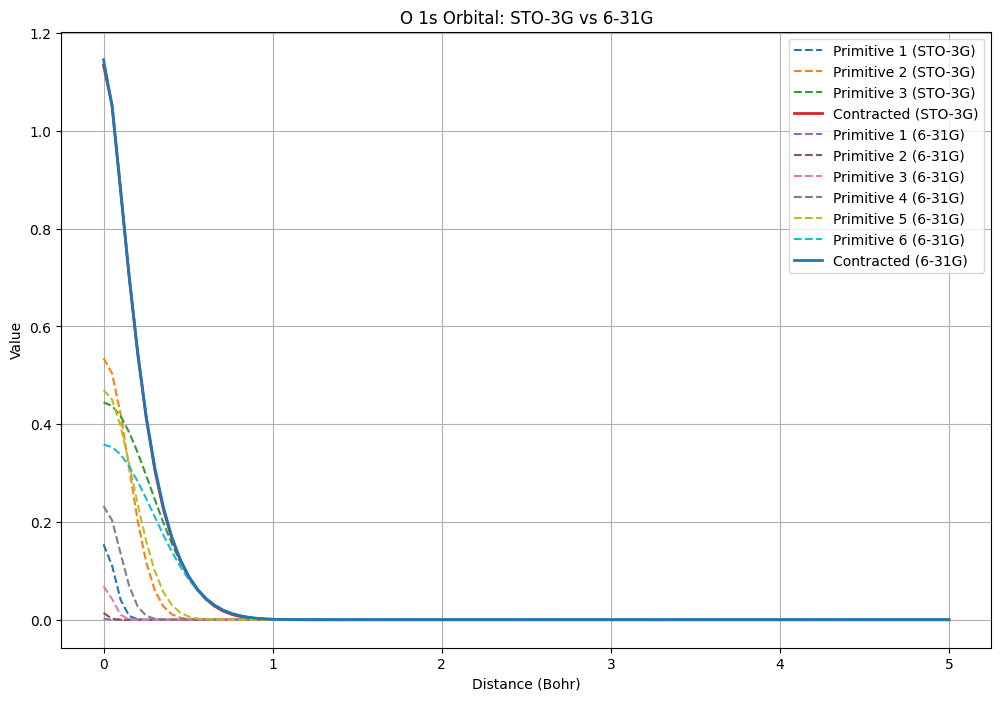

In [194]:
r = np.linspace(0, 5, 100)
plt.figure(figsize=(12,8))

for basis_name, mol in basis_sets.items():
   basis = mol._basis['O'][0]  # O 1s orbital
   angular_momentum = basis[0]
   gto_params = basis[1:]
   alphas = [param[0] for param in gto_params]
   coeffs = [param[1] for param in gto_params]
   
   # Plot primitives
   for i, (alpha, coeff) in enumerate(zip(alphas, coeffs)):
       primitive = coeff * r**angular_momentum * np.exp(-alpha * r**2)
       plt.plot(r, primitive, '--', label=f'Primitive {i+1} ({basis_name})')
   
   # Plot contracted
   contracted = np.zeros_like(r)
   for alpha, coeff in zip(alphas, coeffs):
       contracted += coeff * r**angular_momentum * np.exp(-alpha * r**2)
   plt.plot(r, contracted, '-', linewidth=2, label=f'Contracted ({basis_name})')

plt.title('O 1s Orbital: STO-3G vs 6-31G')
plt.xlabel('Distance (Bohr)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 6. Understanding SCF (self-Consistent Field) Calculation

## 6.1) Introduction to SCF

The SCF method solves the Hatree-Fock equation:

$F\phi_i = \varepsilon_i\phi_i$

where:
- $F$ is the Fock operator
- $\phi_i$ are molecular orbitals
- $\varepsilon_i$ are orbital energies

## 6.2) LCAO Expansion

We express molecular orbitals as linear combinations of basis functions:

$\phi_i = \sum_k c_{ki} \chi_k$

where:
- $\chi_k$ are basis functions (STO-3G, 6-31G, etc.)
- $c_{ki}$ are the coefficients we want to determine


## 6.3) Roothaan Equations

This leads to the matrix equation:

$\mathbf{FC = SC\varepsilon}$

where:
- $\mathbf{F}$: Fock matrix
- $\mathbf{C}$: molecular orbital coefficients
- $\mathbf{S}$: overlap matrix $(\int \chi_i \chi_j dr)$
- $\mathbf{\varepsilon}$: diagonal matrix of orbital energies

## 6.4) Fock Operator and Its Components

The Fock operator is composed of several terms:

$F = h + \sum_j(2J_j - K_j)$

where $h$ is the one-electron operator:
$h = -\frac{1}{2}\nabla^2 - \sum_A\frac{Z_A}{r_{iA}}$

#### Coulomb Operator ($J_j$)
$J_j\phi_i(1) = \left[\int |\phi_j(2)|^2 \frac{1}{r_{12}} dr_2\right]\phi_i(1)$
- Represents classical electron-electron repulsion
- Electron 1 feels average potential from electron 2

#### Exchange Operator ($K_j$)
$K_j\phi_i(1) = \left[\int \phi_j^*(2)\phi_i(2) \frac{1}{r_{12}} dr_2\right]\phi_j(1)$
- Purely quantum mechanical effect
- Arises from antisymmetry requirement
- No classical analogue

#### Physical Interpretation

- $h$: Single electron moving in nuclear field
- $2J_j$: Coulomb repulsion between electrons
- $-K_j$: Exchange correction due to Pauli principle

## 6.4) Deviation of the Roothaan Equation

The Hartree-Fock equation is:

$F\phi_i = \varepsilon_i\phi_i$

According to LCAO expansion, we express the molecular orbital as:

$\phi_i = \sum_\mu c_{\mu i} \chi_\mu$

Then, substitute the LCAO expansion into the HF equations:

$F(\sum_\mu c_{\mu i} \chi_\mu) = \varepsilon_i(\sum_\mu c_{\mu i} \chi_\mu)$

Multiply by $\chi_\nu^*$ and Integrate

$\int \chi_\nu^* F(\sum_\mu c_{\mu i} \chi_\mu)dr = \varepsilon_i \int \chi_\nu^* (\sum_\mu c_{\mu i} \chi_\mu)dr$

Then, Define Matrix Elements

Fock matrix elements: 

$F_{\nu\mu} = \int \chi_\nu^* F \chi_\mu dr$

Overlap matrix elements: 

$S_{\nu\mu} = \int \chi_\nu^* \chi_\mu dr$

This gives us:
$\sum_\mu F_{\nu\mu}c_{\mu i} = \varepsilon_i \sum_\mu S_{\nu\mu}c_{\mu i}$

In matrix notation:
$\mathbf{FC = SC\varepsilon}$

## Oxygen Atom SCF Results and their Analyses

In [1]:
from pyscf import gto, scf
import numpy as np
import matplotlib.pyplot as plt

# Create H atom with different basis sets
mol_sto3g = gto.M(
    atom='O 0 0 0',
    basis='sto-3g',
)

mol_631g = gto.M(
    atom='O 0 0 0',
    basis='6-31g',
)

# Perform SCF calculations
mf_sto3g = scf.RHF(mol_sto3g)
e_sto3g = mf_sto3g.kernel()

mf_631g = scf.RHF(mol_631g)
e_631g = mf_631g.kernel()

print("\nTotal SCF Energy:")
print(f"STO-3G: {e_sto3g:.6f} Hartree")
print(f"6-31G:  {e_631g:.6f} Hartree")

# Let's examine the matrices
print("\nSTO-3G Calculation Details:")
print("\nOverlap Matrix (S):")
print(mf_sto3g.get_ovlp())
print("\nFock Matrix (F):")
print(mf_sto3g.get_fock())
print("\nMO Coefficients (C):")
print(mf_sto3g.mo_coeff)

converged SCF energy = -73.6618168979008
converged SCF energy = -74.655812953603

Total SCF Energy:
STO-3G: -73.661817 Hartree
6-31G:  -74.655813 Hartree

STO-3G Calculation Details:

Overlap Matrix (S):
[[1.         0.23670394 0.         0.         0.        ]
 [0.23670394 1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]

Fock Matrix (F):
[[-20.27795717  -5.16510622   0.           0.           0.        ]
 [ -5.16510622  -2.37400447   0.           0.           0.        ]
 [  0.           0.          -0.40801071   0.           0.        ]
 [  0.           0.           0.          -0.40801071   0.        ]
 [  0.           0.           0.           0.           0.23492616]]

MO Coefficients (C):
[[ 0.99502781 -0.26319948  0.          0.          0.        ]
 [ 0.02019284  1.02905129  0.          0.          0.        

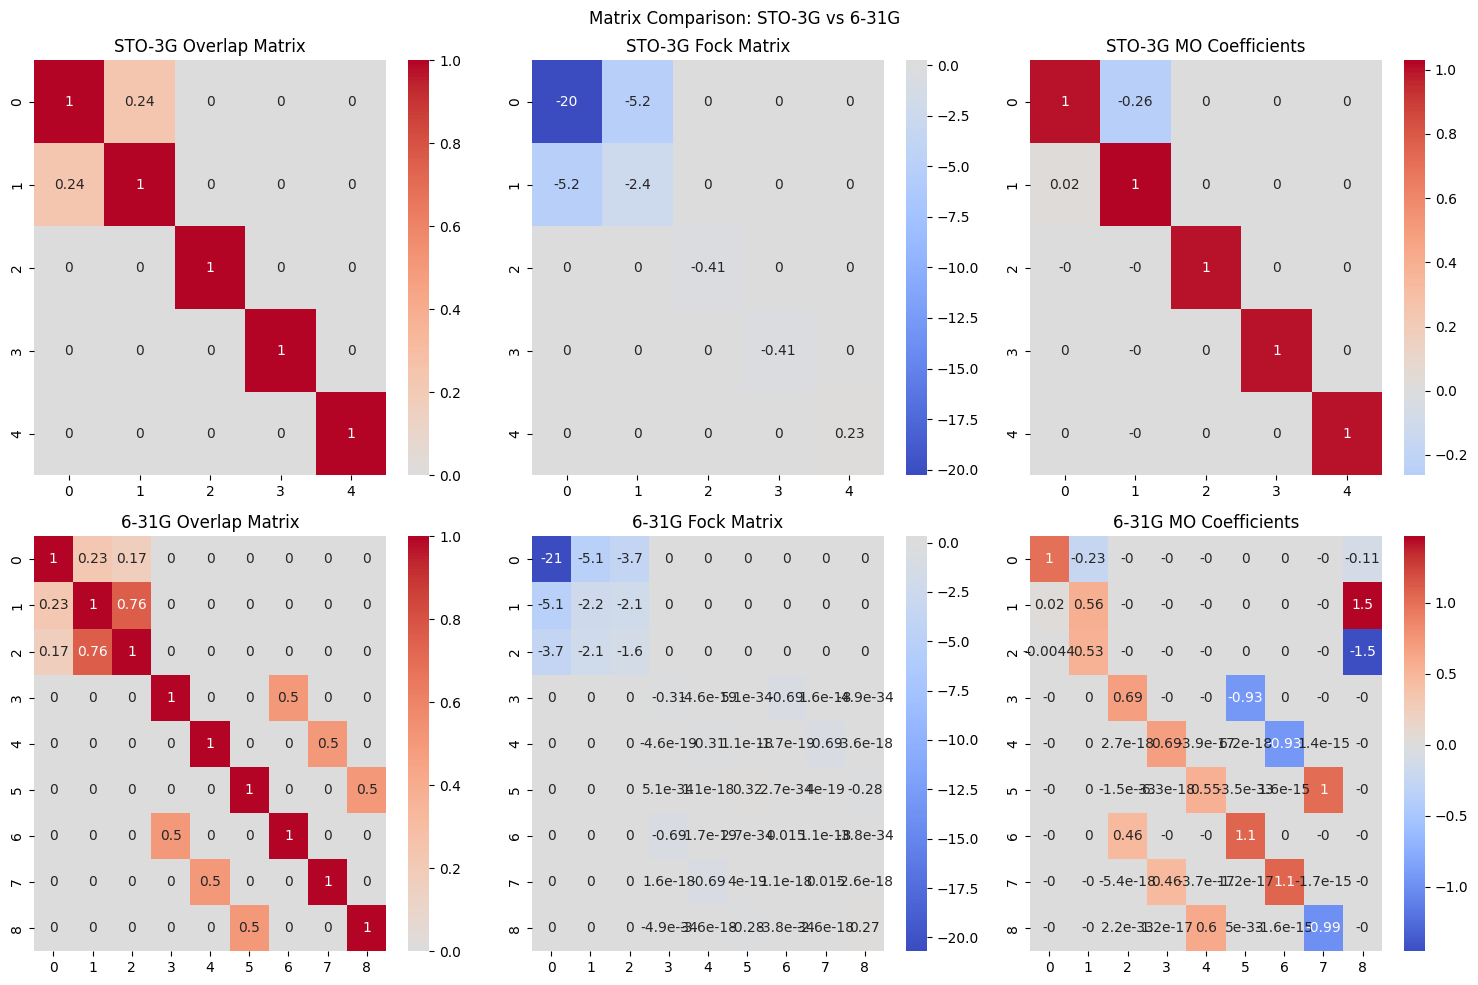

In [3]:
import seaborn as sns

def plot_matrix(matrix, title, ax):
    sns.heatmap(matrix, annot=True, cmap='coolwarm', center=0, ax=ax)
    ax.set_title(title)

# Create subplots for different matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Matrix Comparison: STO-3G vs 6-31G')

# STO-3G matrices
plot_matrix(mf_sto3g.get_ovlp(), 'STO-3G Overlap Matrix', axes[0,0])
plot_matrix(mf_sto3g.get_fock(), 'STO-3G Fock Matrix', axes[0,1])
plot_matrix(mf_sto3g.mo_coeff, 'STO-3G MO Coefficients', axes[0,2])

# 6-31G matrices
plot_matrix(mf_631g.get_ovlp(), '6-31G Overlap Matrix', axes[1,0])
plot_matrix(mf_631g.get_fock(), '6-31G Fock Matrix', axes[1,1])
plot_matrix(mf_631g.mo_coeff, '6-31G MO Coefficients', axes[1,2])

plt.tight_layout()
plt.show()

LCAO Expansion for Each Molecular Orbital

$\phi_i = \sum_\mu c_{\mu i} \chi_\mu$

For oxygen (using coefficients from calculation):

$\phi_{1s} = 0.995\chi_{1s} + 0.020\chi_{2s} + 0\chi_{2p_x} + 0\chi_{2p_y} + 0\chi_{2p_z}$

$\phi_{2s} = -0.263\chi_{1s} + 1.029\chi_{2s} + 0\chi_{2p_x} + 0\chi_{2p_y} + 0\chi_{2p_z}$

$\phi_{2p_x} = 0\chi_{1s} + 0\chi_{2s}  + 1\chi_{2p_x} + 0\chi_{2p_y} + 0\chi_{2p_z}$


Slater Determinant

$\Psi = \frac{1}{\sqrt{N!}}\begin{vmatrix} 
\phi_1(1)\alpha(1) & \phi_1(1)\beta(1) & \phi_2(1)\alpha(1) & \phi_2(1)\beta(1) & \phi_{2p_x}(1)\alpha(1) & \phi_{2p_y}(1)\alpha(1) \\
\phi_1(2)\alpha(2) & \phi_1(2)\beta(2) & \phi_2(2)\alpha(2) & \phi_2(2)\beta(2) & \phi_{2p_x}(2)\alpha(2) & \phi_{2p_y}(2)\alpha(2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\phi_1(8)\alpha(8) & \phi_1(8)\beta(8) & \phi_2(8)\alpha(8) & \phi_2(8)\beta(8) & \phi_{2p_x}(8)\alpha(8) & \phi_{2p_y}(8)\alpha(8)
\end{vmatrix}$

## Visualizing correlation

Here we make a compute object with the Slater determinant wave function, and plot the conditional wave function:
$$
\Psi(r_1 | r_2, R_1, R_2)
$$
where $r_i$ is the position of electron $i$ and $R_i$ is the position of proton $i$.

This function generates a random position of $r_2$ in the plane and then plots the conditional wave function.ㅍ

# Basic Principles
## 2.1 Variational Principle
The energy expectation value of any trial wave function is always greater than or equal to the true ground state energy:
$$
E[\Psi_T] = \frac{\langle\Psi_T|H|\Psi_T\rangle}{\langle\Psi_T|\Psi_T\rangle} \geq E_0
$$

## 2.2 Monte Carlo Integration
Instead of performing exact integration, VMC uses random sampling to estimate expection values:

$$ \langle E \rangle = \int \Psi_T^*(R) H \Psi_T(R) dR \approx \frac{1}{N} \sum_{i=1}^N E_L(R_i)$$

where $E_L(R)$ is the local energy.

## 2.3 Hartree Focks (Mean Field Theory) vs VMC
### 2.3.1 Mean field theory

$$
[-\frac{1}{2}\nabla^2 + V_{nuc}(r) + V_H(r)]\phi_i(r) - \int K(r,r')\phi_i(r')dr' = \epsilon_i\phi_i(r)
$$


where:
- $V_H(r)$ is the Hartree potential (mean field)
- $K(r,r')$ is the exchange operator
- $\phi_i(r)$ are the one-electron orbitals
- $\epsilon_i$ are the orbital energies
  
The electron density for an N-electron system is given by:

$$
\rho(\mathbf{r}) = N\int|\Psi(\mathbf{r},\mathbf{r}_2,...,\mathbf{r}_N)|^2d\mathbf{r}_2...d\mathbf{r}_N
$$
In terms of occupied molecular orbitals:

$$
\rho(\mathbf{r}) = \sum_{i=1}^{N_{occ}}|\psi_i(\mathbf{r})|^2
$$

Properties
1. Normalization:
   $\int\rho(\mathbf{r})d\mathbf{r} = N$

2. Asymptotic behavior:
   $\lim_{r \to \infty}\rho(\mathbf{r}) = 0$

3. Non-negativity:
   $\rho(\mathbf{r}) \geq 0$

Molecular orbitals are expressed as linear combinations of basis functions:

$\psi_i(\mathbf{r}) = \sum_{\mu}c_{\mu i}\chi_{\mu}(\mathbf{r})$

Therefore, the electron density becomes:

$\rho(\mathbf{r}) = \sum_{i=1}^{N_{occ}}\sum_{\mu}\sum_{\nu}c_{\mu i}c_{\nu i}\chi_{\mu}(\mathbf{r})\chi_{\nu}(\mathbf{r})$

   
### Example 1. Hydrogen 1s Orbital
The simplest case - hydrogen atom 1s orbital:

$\psi_{1s}(\mathbf{r}) = \frac{1}{\sqrt{\pi}}\left(\frac{1}{a_0}\right)^{3/2}e^{-r/a_0}$

Electron density:

$\rho_{1s}(\mathbf{r}) = \frac{1}{\pi}\left(\frac{1}{a_0}\right)^3e^{-2r/a_0}$

### Example 2. Helium atom
For helium atom (1s²):

$\rho_{He}(\mathbf{r}) = 2|\psi_{1s}(\mathbf{r})|^2$


### 2.3.1 SCF Procedure
The solution is found iteratively:
1. start with initial guess orbitals
2. Calculate mean-field potential
3. Solve for new orbitals
4. Repeat until convergenceㅠ

### 2.3.2 Trial Wavefunction in VMC: HF + Jastrow

The trial wavefunction is constructed as:

$$
\Psi_T(\mathbf{R}) = \Psi_{HF}(\mathbf{R}) \times e^{J(\mathbf{R})}
$$

where:
- $\Psi_{HF}$: Hartree-Fock Slater determinant
- $J$: Jastrow factor
- $\mathbf{R}$: all electron coordinates

,which means that explicitr electron correlation.

The explicit form is written as:

$$
\Psi_T(\mathbf{R}) = \det[\phi_i(\mathbf{r}_j)] \times \exp[\sum_{i<j} u(r_{ij}) + \sum_{i,I} \chi(r_{iI})]
$$

u(r) = ar/(1 + br)  # e-e correlation\
χ(r) = cr/(1 + dr)  # e-n correlation

a,b,c,d are variational parameters

In [71]:
import pyqmc.api as pyq

mol = pyscf.gto.M(
    atom="""
         H 0. 0. 0.;
         H 0. 0. 2.0
         """,
    ecp="ccecp",
    basis="ccecpccpvdz",
    unit="bohr",
    verbose=5,
)

System: uname_result(system='Darwin', node='wirelessprv-10-193-215-78.near.illinois.edu', release='23.4.0', version='Darwin Kernel Version 23.4.0: Wed Feb 21 21:44:54 PST 2024; root:xnu-10063.101.15~2/RELEASE_ARM64_T6030', machine='arm64')  Threads 1
Python 3.9.20 (main, Oct  3 2024, 02:24:59) 
[Clang 14.0.6 ]
numpy 2.0.2  scipy 1.13.1  h5py 3.12.1
Date: Wed Dec  4 13:42:57 2024
PySCF version 2.7.0
PySCF path  /opt/anaconda3/envs/jaejun2/lib/python3.9/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 5
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = bohr
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr   0.0
[INPUT]  2

In [73]:
mf = pyscf.scf.RHF(mol)
mf.kernel()



******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/tmpvkqaec91
max_memory 4000 MB (current use 0 MB)
cond(S) = 67.45169312325919
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
E1 = -1.9471474368657127  E_coul = 0.697632282245987
init E= -0.749515154619726
    CPU time for initialize scf      0.03 sec, wall time      0.03 sec
  HOMO = -0.426068316512957  LUMO = 0.0849316875203978
  mo_energy =
[-0.42606832  0.08493169  0.70047972  0.84460627  1.31883732  1.31883732
  1.65015221  1.85964567  1.85964567  2.67875606]
E1 = -2.14309477639173  E_coul = 0.5532133356021933
cycle= 1 E= -1.08988144078954  delta_E= -0.34  |g|= 0.043  |d

np.float64(-1.0905378313306195)

In [75]:
wf, _ = pyq.generate_slater(mol,mf)

(10, 2, 3)


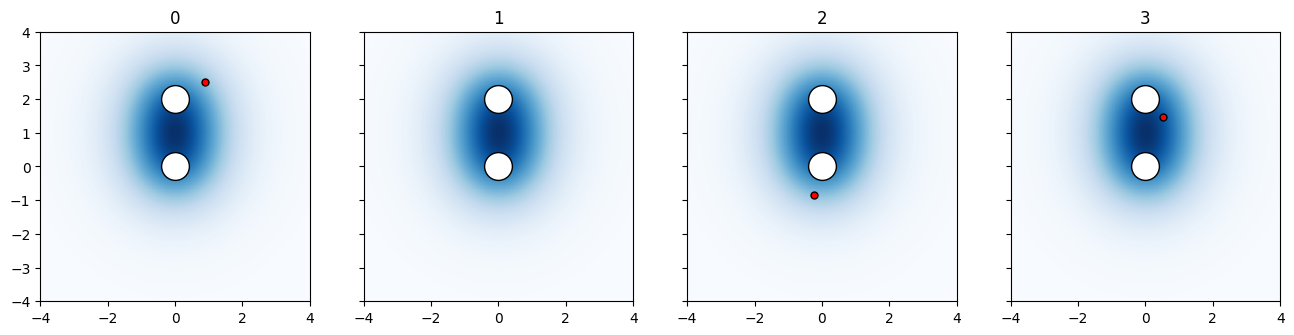

In [113]:
nconf = 10
xval = 2.0

coords = pyq.initial_guess(mol, nconf)
print(coords.configs.shape)
data, coords = pyq.vmc(wf, coords, nblocks=1)

coords.configs[:,1,0] = xval

xmin, xmax = -4, 4
ymin, ymax = -4, 4

x = np.linspace(xmin, xmax, 200)
y = np.linspace(ymin, ymax, 200)
X, Y = np.meshgrid(x,y)

wfval = np.zeros((nconf, np.prod(X.shape)))

wf.recompute(coords)
baseval = wf.value()

for i, (x,y) in enumerate(zip(X.flatten(), Y.flatten())):
    epos = coords.electron(0)
    epos.configs[:,:] = np.array([xval,x,y])[np.newaxis,:]
    testval, tmp = wf.testvalue(0,epos)
    wfval[:,i] = testval*baseval[0]*np.exp(baseval[1])
    
make_plot(coords, wfval, X, Y)
